In [6]:
# ===============================================
# 🧩 STEP 1 — Environment Setup
# ===============================================

!pip install flask==3.0.3 pyngrok==7.2.1 openai-whisper==20231117 jiwer==3.0.4 matplotlib==3.9.2 --quiet

import os
from flask import Flask, request, jsonify, render_template_string
from pyngrok import ngrok
import whisper
from jiwer import wer, cer
import matplotlib.pyplot as plt

# Initialize Flask app
app = Flask(__name__)
print("✅ Environment ready with Flask, Whisper, and jiwer.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 10.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 800.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 742.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s e

In [ ]:
from pyngrok import ngrok
import getpass

auth_token = getpass.getpass("🔑 Enter your ngrok authtoken: ")
ngrok.set_auth_token(auth_token)

print("✅ ngrok authtoken configured securely.")

In [7]:
# ===============================================
# 🧩 STEP 2 — HTML + JS Interface (Dual Input)
# ===============================================

HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<title>🎧 Speech Transcriber Pro</title>
<style>
  body { font-family: Arial; margin: 2rem; text-align: center; }
  #transcript { border: 1px solid #ccc; padding: 1rem; border-radius: 10px; width: 80%; margin: 1rem auto; height: 200px; overflow-y: auto; }
  button, input, select { padding: 10px; border-radius: 10px; margin: 0.5rem; }
</style>
</head>
<body>
  <h2>🎧 Speech Transcriber Pro</h2>
  <p>Use microphone or upload an audio file for transcription.</p>

  <label>🌐 Language:</label>
  <select id="lang">
    <option value="en-US">English (US)</option>
    <option value="en-IN">English (India)</option>
    <option value="hi-IN">Hindi</option>
    <option value="es-ES">Spanish</option>
  </select>
  <br>

  <button id="startBtn">🎙 Start Recording</button>
  <button id="stopBtn" disabled>⏹ Stop</button>
  <br><br>

  <form id="uploadForm" enctype="multipart/form-data">
    <input type="file" id="fileInput" name="audio" accept="audio/*">
    <button type="submit">📁 Upload & Transcribe</button>
  </form>

  <div id="transcript"></div>

<script>
  let recognition;
  let transcriptDiv = document.getElementById('transcript');
  let startBtn = document.getElementById('startBtn');
  let stopBtn = document.getElementById('stopBtn');
  let langSelect = document.getElementById('lang');

  // 🎤 Google Web Speech API
  if (!('webkitSpeechRecognition' in window)) {
    transcriptDiv.innerHTML = "<b>❌ Your browser doesn’t support the Web Speech API.</b>";
  } else {
    recognition = new webkitSpeechRecognition();
    recognition.continuous = true;
    recognition.interimResults = true;

    recognition.onstart = () => {
      transcriptDiv.innerHTML = "<i>Listening...</i><br>";
      startBtn.disabled = true;
      stopBtn.disabled = false;
    };

    recognition.onend = () => {
      transcriptDiv.innerHTML += "<br><i>Stopped.</i><br>";
      startBtn.disabled = false;
      stopBtn.disabled = true;
    };

    recognition.onresult = (event) => {
      let finalTranscript = '';
      for (let i = event.resultIndex; i < event.results.length; ++i) {
        finalTranscript += event.results[i][0].transcript;
      }
      transcriptDiv.innerHTML = finalTranscript;
      fetch('/save', {
        method: 'POST',
        headers: {'Content-Type': 'application/json'},
        body: JSON.stringify({ text: finalTranscript })
      });
    };

    startBtn.onclick = () => {
      recognition.lang = langSelect.value;
      recognition.start();
    };
    stopBtn.onclick = () => recognition.stop();
  }

  // 📁 File Upload (Whisper)
  document.getElementById('uploadForm').onsubmit = async (e) => {
    e.preventDefault();
    const fileInput = document.getElementById('fileInput');
    if (!fileInput.files.length) {
      alert("Please select an audio file first!");
      return;
    }

    const formData = new FormData();
    formData.append("audio", fileInput.files[0]);

    transcriptDiv.innerHTML = "⏳ Transcribing with Whisper...";
    const response = await fetch("/upload", { method: "POST", body: formData });
    const result = await response.json();
    transcriptDiv.innerHTML = "<b>📝 Transcribed Text:</b><br>" + result.text;
  };
</script>
</body>
</html>
"""

@app.route('/')
def index():
    return render_template_string(HTML_TEMPLATE)

In [8]:
# ===============================================
# 🧩 STEP 3 — Flask Backend Logic
# ===============================================

model = whisper.load_model("base")

@app.route('/save', methods=['POST'])
def save_transcript():
    data = request.get_json()
    text = data.get("text", "")
    with open("transcript.txt", "w", encoding="utf-8") as f:
        f.write(text)
    return jsonify({"status": "saved"})

@app.route('/upload', methods=['POST'])
def upload_audio():
    audio_file = request.files['audio']
    file_path = os.path.join("/tmp", audio_file.filename)
    audio_file.save(file_path)

    # Whisper transcription
    result = model.transcribe(file_path)
    text = result['text']

    with open("transcript.txt", "w", encoding="utf-8") as f:
        f.write(text)

    return jsonify({"text": text})

100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 124MiB/s]


In [9]:
# ===============================================
# 🧩 STEP 4 — Run Flask + Ngrok Tunnel
# ===============================================

ngrok.kill()
public_url = ngrok.connect(5000)
print(f"🌐 Access App Here: {public_url}")
app.run(port=5000)


🌐 Access App Here: NgrokTunnel: "https://upturned-undevoutly-felice.ngrok-free.dev" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [07/Nov/2025 08:08:00] "GET / HTTP/1.1" 200 -
/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
INFO:werkzeug:127.0.0.1 - - [07/Nov/2025 08:08:34] "POST /upload HTTP/1.1" 200 -


In [10]:
!pip install openai-whisper --quiet
import whisper

model = whisper.load_model("base")
result = model.transcribe("/content/speech_01.wav")
print(result["text"])

/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 My name is Yvonne and I am excited to have you as part of our learning community. Before we get started, I'd like to tell you a little bit about myself. I'm a sound engineer turned data scientist, curious about machine learning and artificial intelligence. My professional background is primarily in media production, with a focus on audio, IT, and communications.


📘 Reference:
 Hello this is a test of the speech transcription system.
📗 Hypothesis:
  My name is Yvonne and I am excited to have you as part of our learning community. Before we get started, I'd like to tell you a little bit about myself. I'm a sound engineer turned data scientist, curious about machine learning and artificial intelligence. My professional background is primarily in media production, with a focus on audio, IT, and communications.

🔍 Word Error Rate (WER): 5.900
🔍 Character Error Rate (CER): 5.732


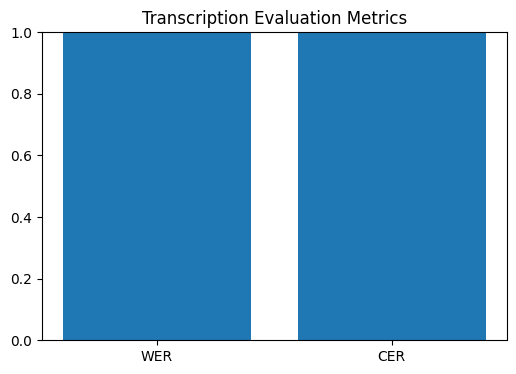

In [11]:
# ===============================================
# 🧩 STEP 5 — Evaluation Metrics
# ===============================================

# Example reference transcript (you can modify)
reference = "Hello this is a test of the speech transcription system."

# Load your latest transcript
with open("transcript.txt", "r", encoding="utf-8") as f:
    hypothesis = f.read()

print("📘 Reference:\n", reference)
print("📗 Hypothesis:\n", hypothesis)

# Compute metrics
word_error = wer(reference, hypothesis)
char_error = cer(reference, hypothesis)

print(f"\n🔍 Word Error Rate (WER): {word_error:.3f}")
print(f"🔍 Character Error Rate (CER): {char_error:.3f}")

# Visualize
plt.figure(figsize=(6,4))
plt.bar(['WER', 'CER'], [word_error, char_error])
plt.title("Transcription Evaluation Metrics")
plt.ylim(0, 1)
plt.show()

In [12]:
# ===============================================
# 🧩 STEP 6 — Generate Evaluation Report
# ===============================================

with open("evaluation_report.txt", "w") as f:
    f.write("Transcription Evaluation Report\n")
    f.write("===============================\n")
    f.write(f"Reference: {reference}\n")
    f.write(f"Hypothesis: {hypothesis}\n\n")
    f.write(f"Word Error Rate (WER): {word_error:.3f}\n")
    f.write(f"Character Error Rate (CER): {char_error:.3f}\n")

print("✅ Report saved as evaluation_report.txt")

✅ Report saved as evaluation_report.txt
